# [1] Scientific computation

There are several packages that provide multidimensional data manipulation, optimization, regression, interpolation and visualization, among other possibilities.

## 0. Some arithmetic insights

### [Integers](https://docs.python.org/3/c-api/long.html)

In python, integers have arbitrary precision and therefore we can represent an arbitrarily large range of integers (only limited by the available memory).

In [15]:
x = 7**273
print(x)
print(type(x))

514949835672429280118340184962210764526557059561644551308225135656646772567852802341125202657808555553768425192667497268234055382589043229395747814284702360571674673819941501856557513477604134701802987908639670470095067188938102407
<class 'int'>


### [Floats](https://docs.python.org/3/tutorial/floatingpoint.html)

Python uses (hardware) [754 double precision representation](https://en.wikipedia.org/wiki/Double-precision_floating-point_format#IEEE_754_double-precision_binary_floating-point_format:_binary64) for floats. This means that some floats can be only represented approximately.

* Using [string format](https://docs.python.org/3.4/library/string.html#string-formatting) to see the precision limitation of **doubles** in Python. For example, it is impossible to represent exactly the number `0.1`:

In [20]:
format(0.1, '.80f')

'0.10000000000000000555111512312578270211815834045410156250000000000000000000000000'

* This can give us *surprises*:

In [24]:
.1 + .1 + .1 == .3

False

In [22]:
.1  + .1 == .2

True

* For "infinite" precision float arithmetic you can use [decimal](https://docs.python.org/3/library/decimal.html#module-decimal) or [mpmath](http://mpmath.org):

In [28]:
from decimal import Decimal, getcontext

* Getting 30 digits of 1/7:

In [29]:
getcontext().prec=80
format(Decimal(1)/Decimal(7), '.80f')

'0.14285714285714285714285714285714285714285714285714285714285714285714285714285714'

* We can see how many digits are true of 1/7 using doubles:

In [30]:
format(1/7, '.80f')

'0.14285714285714284921269268124888185411691665649414062500000000000000000000000000'

In [ ]:
#12345678901234567 (17 digits)

* Decimal arithmetic produces decimal objects:

In [11]:
Decimal(1)/Decimal(7)

Decimal('0.1428571428571428571428571429')

* Decimal objects can be printed with `format`:

In [31]:
print('{:.50f}'.format(Decimal(1)/Decimal(7)))

0.14285714285714285714285714285714285714285714285714


* A more complex example: lets compute 1000 difits ofthe $\pi$ number using the [Bailey–Borwein–Plouffe formula](https://en.wikipedia.org/wiki/Bailey%E2%80%93Borwein%E2%80%93Plouffe_formula):

$$
\pi = \sum_{k = 0}^{\infty}\Bigg[ \frac{1}{16^k} \left( \frac{4}{8k + 1} - \frac{2}{8k + 4} - \frac{1}{8k + 5} - \frac{1}{8k + 6} \right) \Bigg]
$$

In [34]:
# https://stackoverflow.com/questions/28284996/python-pi-calculation
from decimal import Decimal, getcontext
getcontext().prec=1000
my_pi= sum(1/Decimal(16)**k * 
          (Decimal(4)/(8*k+1) - 
           Decimal(2)/(8*k+4) -
           Decimal(1)/(8*k+5) -
           Decimal(1)/(8*k+6)) for k in range(1000))
'{:.1000f}'.format(my_pi)

'3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679821480865132823066470938446095505822317253594081284811174502841027019385211055596446229489549303819644288109756659334461284756482337867831652712019091456485669234603486104543266482133936072602491412737245870066063155881748815209209628292540917153643678925903600113305305488204665213841469519415116094330572703657595919530921861173819326117931051185480744623799627495673518857527248912279381830119491298336733624406566430860213949463952247371907021798609437027705392171762931767523846748184676694051320005681271452635608277857713427577896091736371787214684409012249534301465495853710507922796892589235420199561121290219608640344181598136297747713099605187072113499999983729780499510597317328160963185950244594553469083026425223082533446850352619311881710100031378387528865875332083814206171776691473035982534904287554687311595628638823537875937519577818577805321712268066130019278766111959092164201

You can visit [100,000 Digits of Pi](http://www.geom.uiuc.edu/~huberty/math5337/groupe/digits.html) or [One Million Digits of Pi](http://www.piday.org/million/) to check the correctness this code.

## 1. SciPy.org's [Numpy](http://www.numpy.org/)

Numpy provides a high-performance multidimensional array object.

### 1.1. Installation

```
pip install numpy
```

### 1.2. Why numpy?

Good running times.

In [36]:
import numpy as np

* Lets define a list and compute the sum of its elements, timing it:

In [38]:
l = list(range(0,100000)); print(type(l), l[:10])
%timeit sum(l)

<class 'list'> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
1.4 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


* An now, a numpy's array and timing the sum of its elements:

In [40]:
a = np.arange(0, 100000); print(type(a), a[:10])
%timeit np.sum(a)

<class 'numpy.ndarray'> [0 1 2 3 4 5 6 7 8 9]
76.6 µs ± 3.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


* And what about a *pure* C implementation of an equivalent computation: 

In [41]:
!cat sum_array.c
!gcc -O3 sum_array.c -o sum_array
%timeit !./sum_array

#include <stdio.h>
#include <time.h>
#include "sum_array_lib.c"

#define N 100000

int main() {
  double a[N];
  int i;
  clock_t start, end;
  double cpu_time;
  for(i=0; i<N; i++) {
    a[i] = i;
  }
  start = clock();
  double sum = sum_array(a,N);
  end = clock();
  printf("%f ", sum);
  cpu_time = ((double) (end - start)) / CLOCKS_PER_SEC;
  cpu_time *= 1000000;
  printf("%f usegs\n", cpu_time);
}
4999950000.000000 252.000000 usegs
4999950000.000000 150.000000 usegs
4999950000.000000 150.000000 usegs
4999950000.000000 151.000000 usegs
4999950000.000000 150.000000 usegs
4999950000.000000 150.000000 usegs
4999950000.000000 253.000000 usegs
4999950000.000000 150.000000 usegs
4999950000.000000 252.000000 usegs
4999950000.000000 151.000000 usegs
4999950000.000000 150.000000 usegs
4999950000.000000 150.000000 usegs
4999950000.000000 151.000000 usegs
4999950000.000000 150.000000 usegs
4999950000.000000 151.000000 usegs
4999950000.000000 166.000000 usegs
4999950000.000000 166.000000 usegs

* Looking for informaion of numpy's *something*:

In [42]:
np.lookfor('invert')

Search results for 'invert'
---------------------------
numpy.bitwise_not
    Compute bit-wise inversion, or bit-wise NOT, element-wise.
numpy.matrix.getI
    Returns the (multiplicative) inverse of invertible `self`.
numpy.in1d
    Test whether each element of a 1-D array is also present in a second array.
numpy.isin
    Calculates `element in test_elements`, broadcasting over `element` only.
numpy.transpose
    Permute the dimensions of an array.
numpy.linalg.inv
    Compute the (multiplicative) inverse of a matrix.
numpy.linalg.pinv
    Compute the (Moore-Penrose) pseudo-inverse of a matrix.
numpy.linalg.tensorinv
    Compute the 'inverse' of an N-dimensional array.


* Remember that it's possible to use the tabulator to extend some command or to use a wildcard in Ipython to get the numpy's stuff:

In [43]:
np.*?

### 1.3. Creating (simple) [arrays](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html)
A simple array is a grid of values, all of the same type, indexed by a tuple of nonnegative integers.

### 1.3.1. 1D arrays

* Creating an array using a list:

In [74]:
a = np.array([1, 2, 3])
print(type([1, 2, 3]))
print(type(a))

<class 'list'>
<class 'numpy.ndarray'>


* Getting the number of dimensions of an array:

In [75]:
print(a.ndim)

1


* Printing an array:

In [76]:
print(a)

[1 2 3]


* Printing the *shape* (which always is a tuple) of an array:

In [77]:
print(a.shape)

(3,)


* Mative Python's [`len()`](https://docs.python.org/3.6/library/functions.html#len) also works:

In [78]:
print(len(a))

3


* More a exotic definition using [`linspace()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linspace.html):

In [57]:
np.linspace(1., 4., 6)

array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ])

* And input the data from a file:

In [58]:
np.genfromtxt('data.txt')

array([[   1.,  200.],
       [   2.,  150.],
       [   3.,  250.]])

In [59]:
!cat data.txt

1	200
2	150
3	250


* Arrays can be created from different types of contaniers (which store complex numbers in this case):

In [65]:
c = [[1,1.0],(1+1j,.3)]
print(type(c), type(c[0]), type(c[1]))
x = np.array(c)
x

<class 'list'> <class 'list'> <class 'tuple'>


array([[ 1.0+0.j,  1.0+0.j],
       [ 1.0+1.j,  0.3+0.j]])

* Accesing to an element:

In [61]:
print(a, a[0], a[1])

[1 2 3] 1 2


In [62]:
a[0] = 0
print(a)

[0 2 3]


### 1.3.3. 2D arrays

* Creating a 2D array with 2 1D arrays:

In [67]:
b = np.array([[1,2,3],[4,5,6]])
print(b)
print(b.shape)
print(b[1, 1])

[[1 2 3]
 [4 5 6]]
(2, 3)
5


* With zeroes:

In [80]:
a = np.zeros((5,5))
print(a)

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


* The default dtype is `float64`:

In [82]:
print(type(a[0][0]))

<class 'numpy.float64'>


* With ones:

In [83]:
a = np.ones((5,5))
print(a)

[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]


* With an arbitrary scalar:

In [ ]:
a = np.full((5,5), 2)
print(a)

* The identity matrix:

In [84]:
a = np.eye(5)
print(a)

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


* With random data:

In [85]:
a = np.random.random((5,5))
print(a)

[[ 0.44301741  0.20060797  0.6172475   0.34475764  0.50207486]
 [ 0.15715288  0.44471369  0.88768171  0.27242012  0.24839145]
 [ 0.78642671  0.32731382  0.31078846  0.91625009  0.81577071]
 [ 0.73564192  0.52036881  0.14629184  0.31934008  0.50293865]
 [ 0.7719248   0.50724289  0.57564335  0.00563161  0.64764113]]


In [88]:
a = np.random.random((5,5))
print(a)

[[ 0.43200885  0.48865229  0.66264733  0.58484421  0.80546314]
 [ 0.44119989  0.96775336  0.12654814  0.943149    0.32652329]
 [ 0.68070469  0.39566802  0.58183687  0.69309025  0.60656224]
 [ 0.35138895  0.7714316   0.30747082  0.92323937  0.63667862]
 [ 0.79447268  0.4331374   0.52834092  0.07178817  0.24819771]]


* Filled with [arbitrary](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.empty_like.html) data and with a previously defined shape:

In [90]:
b = np.empty_like(a)
print(b)

[[ 0.43200885  0.48865229  0.66264733  0.58484421  0.80546314]
 [ 0.44119989  0.96775336  0.12654814  0.943149    0.32652329]
 [ 0.68070469  0.39566802  0.58183687  0.69309025  0.60656224]
 [ 0.35138895  0.7714316   0.30747082  0.92323937  0.63667862]
 [ 0.79447268  0.4331374   0.52834092  0.07178817  0.24819771]]


* With a 1D list comprehension:

In [97]:
a = np.array([i for i in range(5)])
print(a, a[1], a.shape)

[0 1 2 3 4] 1 (5,)


* With a 2D list comprehension:

In [105]:
a = np.array([[j+i*5 for j in range(10)] for i in range(5)])
print(a, a.shape)

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]] (5, 10)


* Accesing to a row of a matrix:

In [202]:
a[1] # Get row 2

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

* Accesing to a element of a matrix

In [203]:
a[1][2] # Get column 3 of row 2

7

In [204]:
a[1,2] # Get element of coordinates (1,2)

7

* Getting elements of a matrix using "integer array indexing":

In [107]:
print(a)
print(a[[0, 1, 2], [3, 2, 1]])

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]
[ 3  7 11]


* The same integer array indexing using comprehension lists:

In [108]:
print(a[np.array([i for i in range(3)]), np.array([i for i in range(3,0,-1)])])

[ 3  7 11]


* The same using [`np.arange()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.arange.html):

In [109]:
print(np.arange(3))
print(np.arange(3,0,-1))
print(a[np.arange(3), np.arange(3,0,-1)])

[0 1 2]
[3 2 1]
[ 3  7 11]


### 1.4. Slicing

In [205]:
a = np.array([[j+i*5 for j in range(10)] for i in range(5)])
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

* Get all elements:

* Get all rows of a matrix (the whole matrix):

In [212]:
a[:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [241]:
print(a)
a[::] # Notation: [starting index : stoping index : step]
# By default, start = 0, stop = maximum, step = 1

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [244]:
print(a)
a[0:]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [245]:
print(a)
a[0::]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [246]:
a[:a.shape[1]]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [248]:
a[:a.shape[1]:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

* Get all rows of a matrix, except the first one:

In [240]:
print(a)
a[1:]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [239]:
print(a)
a[1::]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

* Get the first two rows of a matrix:

In [238]:
print(a)
a[0:2]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

* Get the even rows of a matrix:

In [237]:
print(a)
a[0::2]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

* Get the odd columns of a matrix:

In [235]:
print(a)
a[:,1::2]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 1,  3,  5,  7,  9],
       [ 6,  8, 10, 12, 14],
       [11, 13, 15, 17, 19],
       [16, 18, 20, 22, 24],
       [21, 23, 25, 27, 29]])

* Get the odd rows of a matrix:

In [236]:
print(a)
a[:][1::2]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24]])

In [230]:
a[1::2]

array([[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24]])

* Removing the first row:

In [249]:
print(a)
a[1:]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

* Getting the second row:

In [255]:
print(a)
a[1,:]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

* Getting the third column:

In [256]:
print(a)
a[:,2]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([ 2,  7, 12, 17, 22])

* Getting a top-left $2\times 2$ submatrix:

In [257]:
print(a)
a[:2,:2]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[0, 1],
       [5, 6]])

* Getting a bottom-right $2\times 2$ submatrix:

In [258]:
print(a)
a[a.shape[0]-2:,a.shape[1]-2:]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[23, 24],
       [28, 29]])

In [259]:
a[a.shape[0]-2::,a.shape[1]-2::]

array([[23, 24],
       [28, 29]])

* Sampling in horizontal every 2 elements, starting at row 2:

In [260]:
print(a)
a[:,1::2]

[[ 0  1  2  3  4  5  6  7  8  9]
 [ 5  6  7  8  9 10 11 12 13 14]
 [10 11 12 13 14 15 16 17 18 19]
 [15 16 17 18 19 20 21 22 23 24]
 [20 21 22 23 24 25 26 27 28 29]]


array([[ 1,  3,  5,  7,  9],
       [ 6,  8, 10, 12, 14],
       [11, 13, 15, 17, 19],
       [16, 18, 20, 22, 24],
       [21, 23, 25, 27, 29]])

 ### 1.5. Boolean array indexing

* Finding the elements bigger than ...

In [261]:
bool_idx = (a>12)
print(bool_idx)

[[False False False False False False False False False False]
 [False False False False False False False False  True  True]
 [False False False  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]]


* Printing the elements bigger than ...

In [262]:
print(a[bool_idx])

[13 14 13 14 15 16 17 18 19 15 16 17 18 19 20 21 22 23 24 20 21 22 23 24 25
 26 27 28 29]


### 1.6. Elementwise (vectorial-vectorial and vectorial-scalar) math

* Create an zero-ed matrix:

In [263]:
a = np.zeros((5,5), np.int32)
print(a)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


* Change to 1 from coordinate (1,1) to coordinate (4,4):

In [264]:
a[1:4,1:4] = 1
print(a)

[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]


* Vectorial-scalar addition:

In [265]:
a[1:4, 1:4] += 1
print(a)

[[0 0 0 0 0]
 [0 2 2 2 0]
 [0 2 2 2 0]
 [0 2 2 2 0]
 [0 0 0 0 0]]


* A new matriz:

In [266]:
b = np.ones((5,5), np.int32)
print(b)

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


* Vectorial addition:

In [267]:
c = a + b
print(c)

[[1 1 1 1 1]
 [1 3 3 3 1]
 [1 3 3 3 1]
 [1 3 3 3 1]
 [1 1 1 1 1]]


* Vectorial substraction:

In [268]:
d = c - b
print(d)

[[0 0 0 0 0]
 [0 2 2 2 0]
 [0 2 2 2 0]
 [0 2 2 2 0]
 [0 0 0 0 0]]


* Vectorial multiplication (not matrix multiplication!):

In [269]:
c = c * d
print(c)

[[0 0 0 0 0]
 [0 6 6 6 0]
 [0 6 6 6 0]
 [0 6 6 6 0]
 [0 0 0 0 0]]


* Floating-point vectorial division:

In [270]:
c = c / b
print(c)

[[ 0.  0.  0.  0.  0.]
 [ 0.  6.  6.  6.  0.]
 [ 0.  6.  6.  6.  0.]
 [ 0.  6.  6.  6.  0.]
 [ 0.  0.  0.  0.  0.]]


* Fixed-point (integer) vectorial division:

In [271]:
c = d // b
print(c)

[[0 0 0 0 0]
 [0 2 2 2 0]
 [0 2 2 2 0]
 [0 2 2 2 0]
 [0 0 0 0 0]]


### 1.7. Broadcasting
In vectorized operations, NumPy "extends" scalars and arrays with one of its dimensions equal to 1 to the size of the other(s) array(s).

In [272]:
a = np.ones((5,3))
a

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [273]:
b = np.arange(1)
b

array([0])

In [274]:
b += 1
b

array([1])

* Broadcasting of a $1\times 1$ matrix:

In [275]:
a+b # 'a' is 5x3 and 'b' is 1x1

array([[ 2.,  2.,  2.],
       [ 2.,  2.,  2.],
       [ 2.,  2.,  2.],
       [ 2.,  2.,  2.],
       [ 2.,  2.,  2.]])

* Broadcasting of a $1\times 3$ matrix:

In [276]:
b = np.arange(3)
b

array([0, 1, 2])

In [277]:
a+b # 'a' is 5x3 and 'b' is '1x3'

array([[ 1.,  2.,  3.],
       [ 1.,  2.,  3.],
       [ 1.,  2.,  3.],
       [ 1.,  2.,  3.],
       [ 1.,  2.,  3.]])

* Broadcasting of a $5\times 1$ matrix:

In [278]:
b = np.arange(5)
b

array([0, 1, 2, 3, 4])

In [279]:
b = b.reshape((5,1)) # (Rows, Columns)
b

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [280]:
a+b

array([[ 1.,  1.,  1.],
       [ 2.,  2.,  2.],
       [ 3.,  3.,  3.],
       [ 4.,  4.,  4.],
       [ 5.,  5.,  5.]])

If the arrays have different shapes and s can not be "broadcasted", `ValueError: frames are not aligned` is thrown.

In [281]:
b = np.arange(4)[:, None]
b

array([[0],
       [1],
       [2],
       [3]])

In [282]:
a.shape

(5, 3)

In [283]:
b.shape

(4, 1)

In [284]:
a+b

ValueError: operands could not be broadcast together with shapes (5,3) (4,1) 

### 1.8. Matricial math
Provides basic matrix computation.

* Let's define a "chessboard" matrix:

In [285]:
a = np.array([[(i+j)%2 for j in range(10)] for i in range(10)])
print(a, a.shape)

[[0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 0 1 0]
 [0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 0 1 0]
 [0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 0 1 0]
 [0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 0 1 0]
 [0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1 0 1 0]] (10, 10)


... and a 1-column matrix:

In [286]:
b = np.array([[1] for i in range(10)])
print(b, b.shape)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]] (10, 1)


* Product matrix-matrix:

In [287]:
c = np.dot(a,b)
print(c)

[[5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]]


* Sum of all elements of a matrix:

In [288]:
print(np.sum(c))

50


In [289]:
print(np.sum(a))

50


* Compute the maximum of a matrix:

In [290]:
print(np.max(c))

5


* Matrix transpose:

In [291]:
print(c.T, c.T.shape, c.shape)

[[5 5 5 5 5 5 5 5 5 5]] (1, 10) (10, 1)


### 1.9. How fast is array math?

In [292]:
a = np.array([[(i*10+j) for j in range(10)] for i in range(10)])
print(a, a.shape)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]] (10, 10)


In [293]:
a[:1] # First row (a matrix)

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [294]:
a[:1].shape

(1, 10)

In [296]:
a[:1][0] # First element of a matrix of one elment (a vector)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [297]:
a[:1][0].shape

(10,)

In [299]:
b = a[:1][0]
b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

* Add `b[]` to all the rows of `a[][]` using scalar arithmetic:

In [300]:
c = np.empty_like(a)
def add():
    for i in range(a.shape[1]):
        for j in range(a.shape[0]):
            c[i, j] = a[i, j] + b[j]
%timeit add()
print(c)

100 µs ± 6.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
[[  0   2   4   6   8  10  12  14  16  18]
 [ 10  12  14  16  18  20  22  24  26  28]
 [ 20  22  24  26  28  30  32  34  36  38]
 [ 30  32  34  36  38  40  42  44  46  48]
 [ 40  42  44  46  48  50  52  54  56  58]
 [ 50  52  54  56  58  60  62  64  66  68]
 [ 60  62  64  66  68  70  72  74  76  78]
 [ 70  72  74  76  78  80  82  84  86  88]
 [ 80  82  84  86  88  90  92  94  96  98]
 [ 90  92  94  96  98 100 102 104 106 108]]


* Add `b[]` to all the rows of `a[][]` using vectorial arithmetic:

In [301]:
c = np.empty_like(a)
def add():
    for i in range(a.shape[1]):
        c[i, :] = a[i, :] + b
%timeit add()
print(c)

31.4 µs ± 787 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
[[  0   2   4   6   8  10  12  14  16  18]
 [ 10  12  14  16  18  20  22  24  26  28]
 [ 20  22  24  26  28  30  32  34  36  38]
 [ 30  32  34  36  38  40  42  44  46  48]
 [ 40  42  44  46  48  50  52  54  56  58]
 [ 50  52  54  56  58  60  62  64  66  68]
 [ 60  62  64  66  68  70  72  74  76  78]
 [ 70  72  74  76  78  80  82  84  86  88]
 [ 80  82  84  86  88  90  92  94  96  98]
 [ 90  92  94  96  98 100 102 104 106 108]]


* Add `b[]` to all the rows of `a[][]` using fully vectorial arithmetic:

In [302]:
%timeit c = a + b # <- broadcasting is faster
print(c)

4.26 µs ± 461 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
[[  0   2   4   6   8  10  12  14  16  18]
 [ 10  12  14  16  18  20  22  24  26  28]
 [ 20  22  24  26  28  30  32  34  36  38]
 [ 30  32  34  36  38  40  42  44  46  48]
 [ 40  42  44  46  48  50  52  54  56  58]
 [ 50  52  54  56  58  60  62  64  66  68]
 [ 60  62  64  66  68  70  72  74  76  78]
 [ 70  72  74  76  78  80  82  84  86  88]
 [ 80  82  84  86  88  90  92  94  96  98]
 [ 90  92  94  96  98 100 102 104 106 108]]


### 1.10. Structured arrays

* Create a 1D array of (two) records, where each record has the structure (int, float, char[10]).

In [307]:
x = np.array([(1,2.,'Hello'), (3,4.,"World")],
             dtype=[('first', 'i4'),('second', 'f4'), ('third', 'S10')])
x

array([(1,  2., b'Hello'), (3,  4., b'World')],
      dtype=[('first', '<i4'), ('second', '<f4'), ('third', 'S10')])

* Get the first element of every record:

In [312]:
x['first']

array([1, 3], dtype=int32)

* Get the first record:

In [313]:
x[0]

(1,  2., b'Hello')

* Get the second element of every record:

In [314]:
x['second']

array([ 2.,  4.], dtype=float32)

* Third element of every record:

In [315]:
x['third']

array([b'Hello', b'World'],
      dtype='|S10')

## 2. [Matplotlib](http://matplotlib.org)
A Python 2D plotting library.

### 2.1. Installation

```
pip install matplotlib
```

### 2.2. Configure Matplotlib in-line of Ipython (Jupyter) notebook

In [316]:
%matplotlib inline

### 2.3. Importing it

In [317]:
import matplotlib.pyplot as plt

### 2.4. Drawing data structures (matrices):

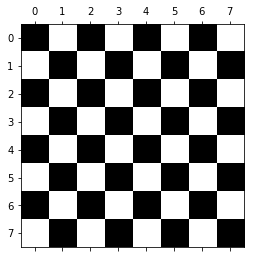

In [318]:
chess_board = np.zeros([8, 8], dtype=int)
chess_board[0::2, 1::2] = 1
chess_board[1::2, 0::2] = 1
plt.matshow(chess_board, cmap=plt.cm.gray)

### 2.5. Drawing 2D curves

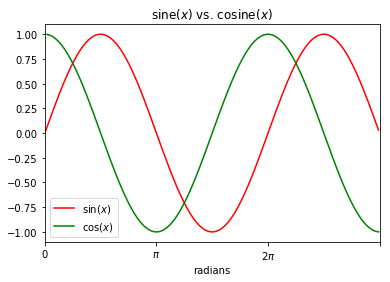

In [319]:
resolution = 100
x = np.arange(0, 3*np.pi, np.pi/resolution)
si = np.sin(x)
co = np.cos(x)
plt.plot(x, si, c = 'r')
plt.plot(x, co, c = 'g')
plt.legend(['$\sin(x)$', '$\cos(x)$'])
plt.xlabel('radians')
plt.title('sine($x$) vs. cosine($x$)')
plt.xticks(x*resolution, ['0', '$\pi$', '$2\pi$'], rotation='horizontal')
plt.xlim(0,3*np.pi)
plt.show()

### 2.6. Drawing 3D curves

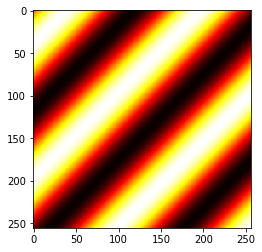

In [320]:
x = np.array([[(x+y)/25 for x in range(256)] for y in range(256)])
si = np.sin(x)
plt.imshow(si, cmap='hot', interpolation='nearest')
plt.show()

<a list of 13 text.Text objects>

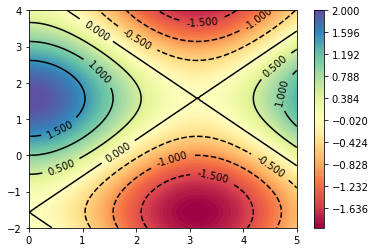

In [321]:
# https://github.com/AeroPython/Taller-Aeropython-PyConEs16
def funcion(x,y):
    return np.cos(x) + np.sin(y)

x_1d = np.linspace(0, 5, 100)
y_1d = np.linspace(-2, 4, 100)
X, Y = np.meshgrid(x_1d, y_1d)
Z = funcion(X,Y)
plt.contourf(X, Y, Z, np.linspace(-2, 2, 100),cmap=plt.cm.Spectral)
plt.colorbar()
cs = plt.contour(X, Y, Z, np.linspace(-2, 2, 9), colors='k')
plt.clabel(cs)

## 3. [SciPy](https://docs.scipy.org/doc/scipy/reference/)
[SciPy](http://cs231n.github.io/python-numpy-tutorial/#numpy-array-indexing) provides a large number of functions that operate on numpy arrays and are useful for different types of scientific and engineering applications such as:
1. [Custering](https://docs.scipy.org/doc/scipy/reference/cluster.html).
2. [Discrete Fourier Analysis](https://docs.scipy.org/doc/scipy/reference/fftpack.html).
3. [Interpolation](https://docs.scipy.org/doc/scipy/reference/interpolate.html).
4. [Linear algebra](https://docs.scipy.org/doc/scipy/reference/linalg.html).
5. [Signal](https://docs.scipy.org/doc/scipy/reference/signal.html) and [Image processing](https://docs.scipy.org/doc/scipy/reference/ndimage.html).
6. [Optimization](https://docs.scipy.org/doc/scipy/reference/optimize.html).
7. [Sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html) and [sparse linear algebra](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html).



### 3.1. Installation

```
pip install scipy
```

### 3.1.1. Optimization example

In [325]:
# http://www.scipy-lectures.org/advanced/mathematical_optimization/
from scipy import optimize

In [326]:
def f(x):
    return -np.exp(-(x - .7)**2)

In [327]:
sol = optimize.brent(f)
print('min =', sol, '\nx =', f(sol))

min = 0.699999999784 
x = -1.0


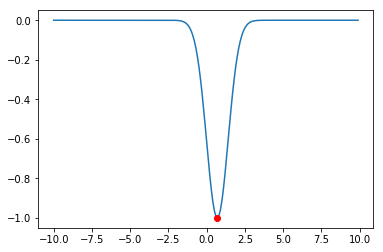

In [328]:
x = np.arange(-10, 10, 0.1)
plt.plot(x, f(x))
plt.plot([sol],[f(sol)], 'ro')
plt.show()

## 4. [Pandas](http://pandas.pydata.org/)
High-performance data structures and data analysis tools for the Python programming language (similar to [R](https://en.wikipedia.org/wiki/R_(programming_language)). Some tools are:
1. [Statistical functions (covariance, correlation)](http://pandas.pydata.org/pandas-docs/stable/computation.html#statistical-functions).
2. [Window functions](http://pandas.pydata.org/pandas-docs/stable/computation.html#window-functions).
3. [Time series](http://pandas.pydata.org/pandas-docs/stable/timeseries.html).
4. [Analysis of sparse data](http://pandas.pydata.org/pandas-docs/stable/sparse.html).

### 4.1. Installation

```
pip3 install pandas
```

### 4.2. Example

Create a table with data:

In [329]:
import numpy as np
import pandas as pd
df = pd.DataFrame({'int_col' : [1, 2, 6, 8, -1],
                    'float_col' : [0.1, 0.2, 0.2, 10.1, None],
                    'str_col' : ['a', 'b', None, 'c', 'a']})
print(df)
df

ModuleNotFoundError: No module named 'pandas'

Arithmetic average of a column:

In [ ]:
df2 = df.copy()
mean = df2['float_col'].mean()
mean

Replace undefined elements:

In [ ]:
df3 = df['float_col'].fillna(mean)
df3

Create a table by means of columns:

In [ ]:
df4 = pd.concat([df3, df['int_col'], df['str_col']], axis=1)
df4

## 5. [SymPy](http://www.sympy.org/en/index.html)
A Python library for symbolic mathematics. Among others things, it provides:
1. [Symbolic simplification](http://docs.sympy.org/latest/tutorial/simplification.html).
2. [Calculus (derivatives, integrals, limits, and series expansions)](http://docs.sympy.org/latest/tutorial/calculus.html).
3. [Algebraic solver](http://docs.sympy.org/latest/tutorial/solvers.html).
4. [Matrix operations](http://docs.sympy.org/latest/tutorial/matrices.html).
5. [Combinatorics](http://docs.sympy.org/latest/modules/combinatorics/index.html)
6. [Cryptography](http://docs.sympy.org/latest/modules/crypto.html).

### 5.1. Install
```
pip install sympy
```

### 5.2. Example

In [ ]:
from sympy import init_session
init_session(use_latex='matplotlib')

In [ ]:
# https://github.com/AeroPython/Taller-Aeropython-PyConEs16
expr = cos(x)**2 + sin(x)**2
expr

In [ ]:
simplify(expr)

In [ ]:
expr.subs(x, y**2)

In [ ]:
expr = (x + y) ** 2
expr

In [ ]:
expr = expr.expand()
expr

In [ ]:
expr = expr.factor()
expr

In [ ]:
expr = expr.integrate(x)
expr

In [ ]:
expr = expr.diff(x)
expr